### Load Data

In [8]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


energy_data = pd.read_csv('/Users/danielhoang/Documents/GitHub/02807 Computational Tools for Data Science/Project/owid-energy.csv')

energy_data.head()


country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  Afghanistan  1900      AFG   4832414.0  NaN                      NaN   
1  Afghanistan  1901      AFG   4879685.0  NaN                      NaN   
2  Afghanistan  1902      AFG   4935122.0  NaN                      NaN   
3  Afghanistan  1903      AFG   4998861.0  NaN                      NaN   
4  Afghanistan  1904      AFG   5063419.0  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0                      NaN  ...               NaN                 NaN   
1                      NaN  ...               NaN                 NaN   
2                      NaN  ...               NaN                 NaN   
3                      NaN  ...               NaN                 NaN   
4                      NaN  ...               NaN                 NaN   

   wind_cons_change_pct  wind_cons_change_twh  wind_consumption  \
0                   NaN                   NaN               NaN   
1                   NaN                   NaN               NaN   
2                   NaN                   NaN               NaN   
3                   NaN                   NaN               NaN   
4                   NaN                   NaN               NaN   

   wind_elec_per_capita  wind_electricity  wind_energy_per_capita  \
0                   NaN               NaN                     NaN   
1                   NaN               NaN                     NaN   
2                   NaN               NaN                     NaN   
3                   NaN               NaN                     NaN   
4                   NaN               NaN                     NaN   

   wind_share_elec  wind_share_energy  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 129 columns]

### Find energy source for each and filter out 'None'

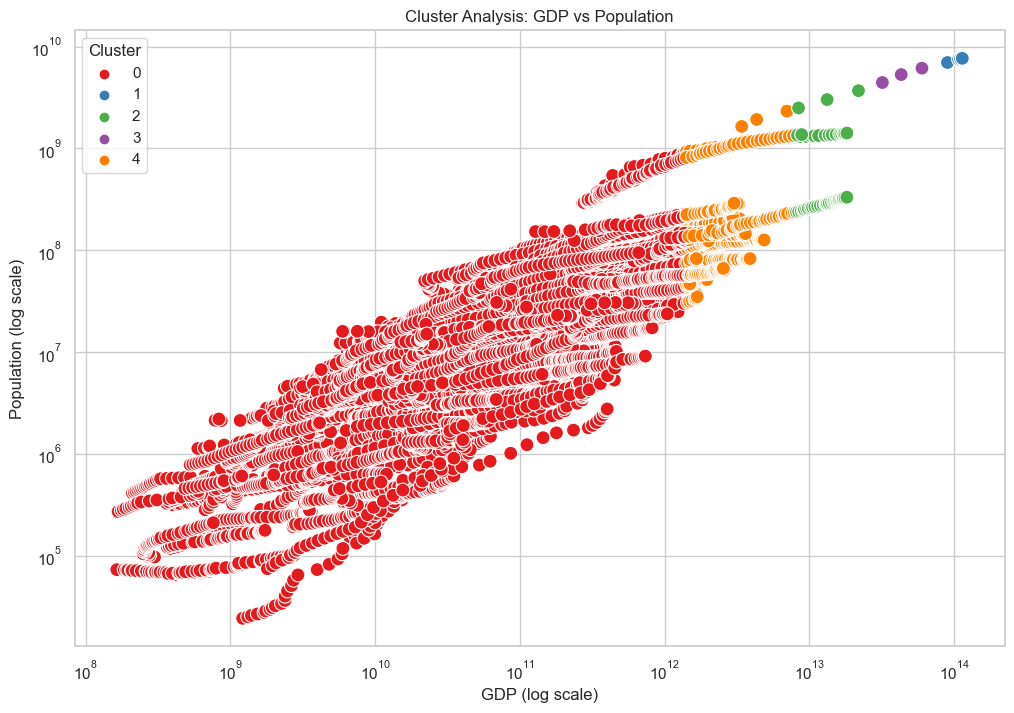

In [9]:

# Define specific energy types for key analysis
key_energy_types = ['coal_consumption', 'oil_consumption', 'gas_consumption', 
                    'nuclear_consumption', 'hydro_consumption', 'solar_consumption', 
                    'wind_consumption', 'other_renewable_consumption']
# Normalize the energy consumption data for clustering
energy_data_normalized = energy_data[key_energy_types].div(energy_data[key_energy_types].sum(axis=1), axis=0).fillna(0)

# Add GDP and population data for clustering
energy_data_for_clustering = energy_data_normalized.copy()
energy_data_for_clustering['gdp'] = energy_data['gdp']
energy_data_for_clustering['population'] = energy_data['population']
energy_data_for_clustering['country'] = energy_data['country']

# Filter out missing values - NA values
energy_data_for_clustering = energy_data_for_clustering.dropna(subset=['gdp', 'population'])

# Select only numeric data for KMeans clustering
numeric_data_for_clustering = energy_data_for_clustering[['gdp', 'population'] + key_energy_types]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, n_init=10)  # 5 clusters
cluster_labels = kmeans.fit_predict(numeric_data_for_clustering)

# Assign the cluster labels to your DataFrame
energy_data_for_clustering['cluster'] = cluster_labels

# Cluster visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(x='gdp', y='population', hue='cluster', data=energy_data_for_clustering, palette='Set1', s=100)
plt.title('Cluster Analysis: GDP vs Population')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP (log scale)')
plt.ylabel('Population (log scale)')
plt.legend(title='Cluster', loc='upper left')
plt.show()


scatter plot displays countries clustered by their GDP and population, both on a logarithmic scale to accommodate the wide range of values. Five clusters are evident, with the red cluster representing many countries with lower GDP and populations, and the green, purple, and blue clusters corresponding to countries with higher GDPs, indicating various levels of economic development and population sizes. The distribution suggests that countries with higher GDPs often have larger populations, although there are notable exceptions, reflecting the diversity in economic structures and population dynamics globally.

In [10]:
# Select the most recent year's data for each country
most_recent_data = energy_data[energy_data['year'] == energy_data['year'].max()-1].copy()

# Handle NaN values and ensure all values are non-negative
most_recent_data[key_energy_types] = most_recent_data[key_energy_types].fillna(0).clip(lower=0)

# Normalize the data by dividing by the sum across each row
# Replace 'inf' values resulting from division by zero with NaN
sums = most_recent_data[key_energy_types].sum(axis=1).replace(0, np.nan)
most_recent_data_normalized = most_recent_data[key_energy_types].div(sums, axis=0)

# Ensure all columns in key_energy_types are numeric
for column in key_energy_types:
    most_recent_data_normalized[column] = pd.to_numeric(most_recent_data_normalized[column], errors='coerce')

# Define a function to get the predominant energy source
def get_predominant_energy_source(row):
    # Use a try-except block to handle any potential issues with idxmax
    try:
        return row.idxmax()
    except TypeError:
        return None

# Apply the function to determine the predominant energy source
most_recent_data['predominant_energy_source'] = most_recent_data_normalized.apply(get_predominant_energy_source, axis=1)

# Add country information to the normalized DataFrame
most_recent_data['country'] = most_recent_data['country']

# Create a DataFrame for energy source data
energy_source_data = most_recent_data[['country', 'predominant_energy_source']]

print(energy_source_data.head())


            country predominant_energy_source
121     Afghanistan                       NaN
243          Africa           oil_consumption
300     Africa (BP)           oil_consumption
322  Africa (Ember)                       NaN
682         Algeria           gas_consumption


In [11]:
from sklearn.preprocessing import MinMaxScaler


# Handle NaN values for all columns at once
most_recent_data[key_energy_types] = most_recent_data[key_energy_types].apply(
    lambda column: column.fillna(0) if column.isna().all() else column.fillna(column.mean())
)

# Normalize the data
scaler = MinMaxScaler()
energy_profiles_normalized = pd.DataFrame(
    scaler.fit_transform(most_recent_data[key_energy_types]), 
    columns=key_energy_types, 
    index=most_recent_data.index
)

# Calculate the cosine similarity
similarity_matrix = cosine_similarity(energy_profiles_normalized)

# Create a DataFrame from the similarity matrix
countries = most_recent_data['country'].unique()  # List of countries
similarity_df = pd.DataFrame(similarity_matrix, index=countries, columns=countries)

print (similarity_df.head(20))


                     Afghanistan    Africa  Africa (BP)  Africa (Ember)  \
Afghanistan                  0.0  0.000000     0.000000             0.0   
Africa                       0.0  1.000000     1.000000             0.0   
Africa (BP)                  0.0  1.000000     1.000000             0.0   
Africa (Ember)               0.0  0.000000     0.000000             0.0   
Algeria                      0.0  0.700504     0.700504             0.0   
American Samoa               0.0  0.000000     0.000000             0.0   
Angola                       0.0  0.000000     0.000000             0.0   
Antigua and Barbuda          0.0  0.000000     0.000000             0.0   
Argentina                    0.0  0.855113     0.855113             0.0   
Armenia                      0.0  0.000000     0.000000             0.0   
Aruba                        0.0  0.000000     0.000000             0.0   
Asia                         0.0  0.856853     0.856853             0.0   
Asia (Ember)             

### Plot

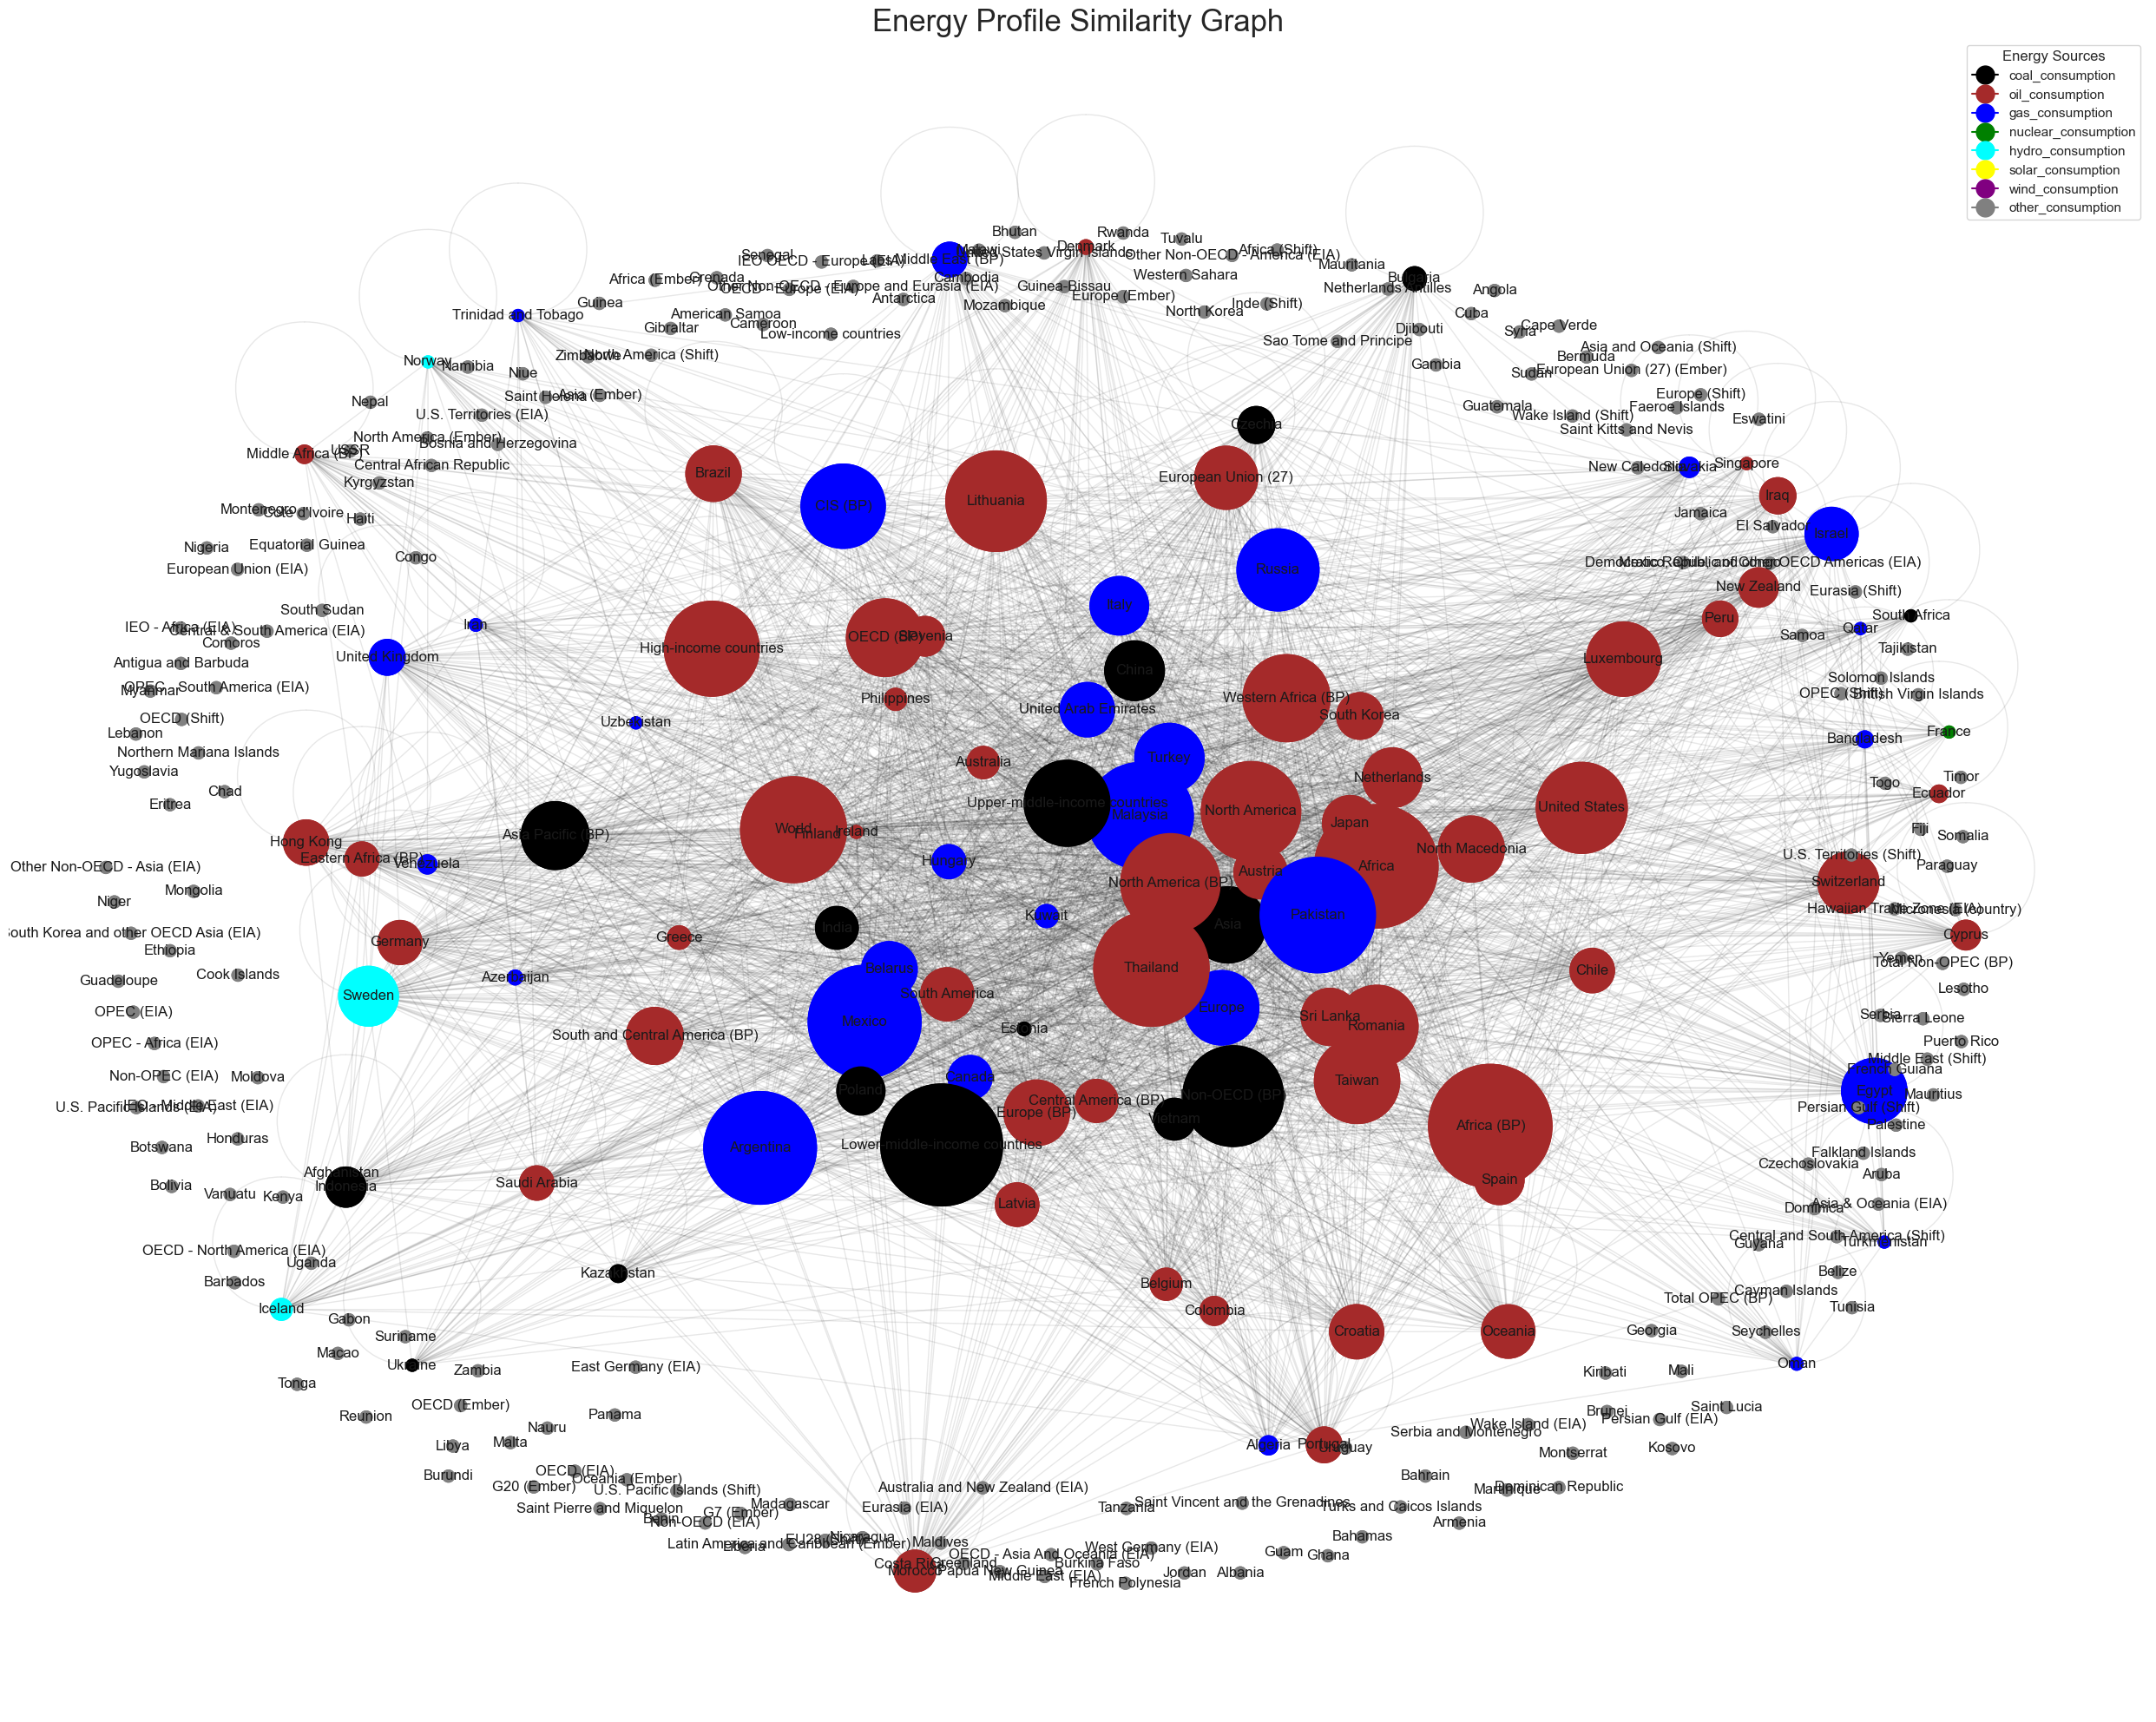

In [37]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain

energy_source_colors = {
    'coal_consumption': 'black',
    'oil_consumption': 'brown',
    'gas_consumption': 'blue',
    'nuclear_consumption': 'green',
    'hydro_consumption': 'cyan',
    'solar_consumption': 'yellow',
    'wind_consumption': 'purple',
    'other_consumption': 'grey'}

G = nx.Graph()

# Add nodes for each country
for country in energy_data['country']:
    G.add_node(country)

threshold = 0.5  # threshold for similarity to add an edge

# Add edges based on similarity in energy profiles
for i in similarity_df.index:
    for j in similarity_df.columns:
        if similarity_df.loc[i, j] > threshold:
            G.add_edge(i, j)

# Calculate centrality
centrality = nx.betweenness_centrality(G)

# Adjust k and iterations as needed
pos = nx.spring_layout(G, k=1.85, iterations=50)

plt.figure(figsize=(25, 20))  # Adjust figure size as needed

# Adjust the multiplier (to see scaling effect)
node_size = [centrality[node] * 5000000 for node in G.nodes()]

# assign a color to each node based on its predominant energy source
for node in G.nodes():
    # Find the predominant energy source for the country (node)
    if node in energy_source_data['country'].values:
        predominant_source = energy_source_data[energy_source_data['country']
                                                == node]['predominant_energy_source'].iloc[0]
        node_color = energy_source_colors.get(
            predominant_source, 'grey')  # Default to 'grey' if not found
    else:
        node_color = 'grey'  # Assign 'grey' if country is not in energy_source_data
    # Assign the color to the node
    G.nodes[node]['color'] = node_color

# draw the nodes with a minimum size and full opacity
min_node_size = 100  # Define a minimum node size for visibility
nodes = nx.draw_networkx_nodes(
    G, pos,
    # Ensure nodes are at least min_node_size
    node_size=[max(size, min_node_size) for size in node_size],
    node_color=[data['color'] for _, data in G.nodes(data=True)],
    alpha=1 
)

edges = nx.draw_networkx_edges(G, pos, alpha=0.1)

# draw nodes again to ensure they are on top of the edges
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=[max(size, min_node_size) for size in node_size],
    node_color=[data['color'] for _, data in G.nodes(data=True)],
    alpha=1
)

# Draw labels 
labels = nx.draw_networkx_labels(G, pos, font_size=12)

# Add a legend for energy sources
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=source,
               markersize=15, markerfacecolor=color)
    for source, color in energy_source_colors.items()
]

plt.legend(handles=legend_elements, title="Energy Sources",
           loc='best', bbox_to_anchor=(1, 1))

plt.title("Energy Profile Similarity Graph", size=25)
plt.axis('off')

plt.tight_layout()#spreading it out a bit more
plt.show()